# 事前準備

所定のデータをダウンロードしてそれぞれ"data"ディレクトリに格納してください。
- sp500.csv: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
- nasdaq100.csv https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- nasdaq.csv: https://finance.yahoo.com/quote/%5ENDX/history?p=%5ENDX

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import namedtuple

# データ読み込み及び前処理

In [2]:
file_names = ['sp500', 'nasdaq100']
datas = {k: pd.read_csv(f'data/{k}.csv') for k in file_names}

In [3]:
#前日比のカラムを作る
for key in datas.keys():
    close = datas[key]['Adj Close']
    datas[key] = datas[key].drop(0)#一つ目のデータだけ前日比が取れないので捨てる
    diff_percent = close.diff().values[1:]/close.values[:-1]
    datas[key]['day_ratio'] = diff_percent

# レバレッジの価格算出に誤りがないか検証

In [4]:
spxl = pd.read_csv('data/SPXL.csv')
close = spxl['Adj Close']
spxl = spxl.drop(0)
spxl['day_ratio'] = close.diff().values[1:]/close.values[:-1]
spxl.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day_ratio
1,2008-11-06,4.150000,4.197500,3.552500,3.600000,2.888150,4332000,-0.152941
2,2008-11-07,3.707500,3.887500,3.611667,3.854167,3.092059,6978000,0.070602
3,2008-11-10,4.150000,4.161667,3.584167,3.704167,2.971719,5785200,-0.038919
4,2008-11-11,3.541667,3.687500,3.291667,3.459167,2.775165,11479200,-0.066142
5,2008-11-12,3.327500,3.327500,3.017500,3.074167,2.466293,13312800,-0.111299


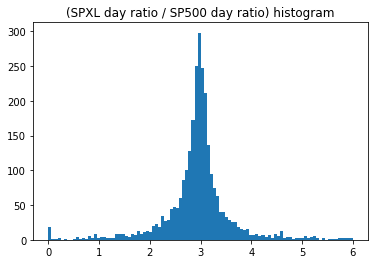

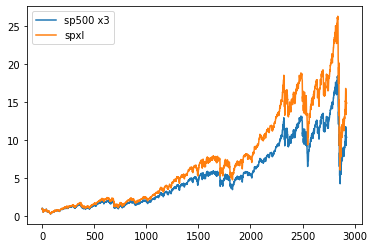

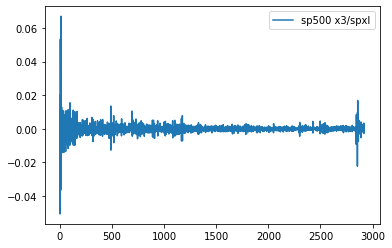

In [5]:
vs_spxl_sp500 = datas['sp500'].query('Date >= "2008-11-06"')
vs_spxl_sp500_plus1 = vs_spxl_sp500['day_ratio'].values+1
rr = spxl.day_ratio.values/(vs_spxl_sp500.day_ratio.values+ 1e-9)
plt.title('(SPXL day ratio / SP500 day ratio) histogram')
_ = plt.hist(rr, bins=100, range=(0,6))
plt.show()

n = 0
N = -1
sp500_ratio_3 = vs_spxl_sp500.day_ratio*3 + 1
cumprod_sp500_ratio_3 = np.cumprod(sp500_ratio_3.values)
t1 = (cumprod_sp500_ratio_3/cumprod_sp500_ratio_3[n])[n:N]
t2 = (spxl['Adj Close'].values/spxl['Adj Close'].iloc[n])[n:N]
plt.plot(t1, label='sp500 x3')
plt.plot(t2, label='spxl')
plt.legend()
plt.show()
plt.plot(np.diff(t1/t2), label='sp500 x3/spxl')
plt.legend()
plt.show()

# もしリーマンショック以前にレバレッジETFがあったら

In [6]:
leverage = 3
for k in file_names:
    datas[k+'_x3'] = pd.DataFrame()
    ratio = datas[k].day_ratio*3
    #ratio.loc[ratio <= 0] = 1e-9
    datas[k+'_x3']['day_ratio'] = ratio 
    datas[k+'_x3']['Adj Close'] = np.cumprod(ratio+1)
    datas[k+'_x3']['Date'] = datas[k].Date

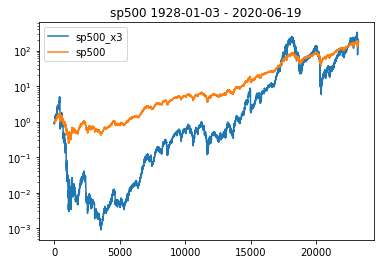

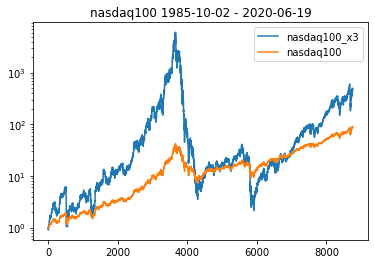

In [7]:
for k in file_names:
    x = datas[k].Date
    plt.title(f"{k} {x.iloc[0]} - {x.iloc[-1]}")
    l = k+'_x3'
    plt.plot(datas[l]['Adj Close']/datas[l]['Adj Close'].iloc[0], label=l)
    l = k
    plt.plot(datas[l]['Adj Close']/datas[l]['Adj Close'].iloc[0], label=l)
    plt.yscale('log')
    plt.legend()
    plt.show()

In [8]:
results = {k:{} for k in datas.keys()}

# 買ったETF5年後どうなってる？

In [34]:
def exe1(values, day_num, iteration):
    res = []
    starts = np.random.choice(np.arange(len(values)-day_num), iteration) 
    for start in starts:
        res.append(values.iloc[start+day_num-1]/values.iloc[start])
    return res

In [35]:
def make_data(exe, name, years=[1,5,10], **kwargs):
    for k in datas.keys():
        results[k][name] = {}
        for n in years:
            results[k][name][n] = exe(datas[k]['Adj Close'], day_num=n*365, **kwargs)

In [36]:
make_data(exe1, 'exe1', iteration=10000)

In [38]:
def show_hist(name, iteration=10000, years=[1,5,10], bins=40, ranges=[[0,4], [0,40]], ):
    for n in years:
        for k in ['sp500', 'sp500_x3', 'nasdaq100', 'nasdaq100_x3']:
            if k[-1] != '3':
                for r in ranges:
                    #num, bins, patches = plt.hist([results[k][name][n], results[k+'_x3'][name][n]], bins=bins, ) # histogram
                    num1, _bins, _ = plt.hist(results[k][name][n], histtype='stepfilled', alpha=0.3, label=k+'_x1', range=r, bins=bins)
                    num2, _bins, _ = plt.hist(results[k+'_x3'][name][n], histtype='stepfilled', alpha=0.3, label=k+'_x3', range=r, bins=bins)
                    plt.grid()
                    plt.legend()
                    plt.xlabel('benfit x')
                    plt.ylabel('times')
                    plt.show()
                    for i,_n in enumerate([num1, num2]):
                        plt.plot(_bins[:-1], np.cumsum(_n)/iteration*100, )
                    plt.legend([k+'_x1', k+'_x3'], loc='best')
                    plt.xlabel('benfit x')
                    plt.ylabel('%')
                    plt.grid()
                    plt.show()
               
            print(f'{n}年 {k}: mean={np.mean(results[k][name][n])} min={np.min(results[k][name][n])} max={np.max(results[k][name][n])}')

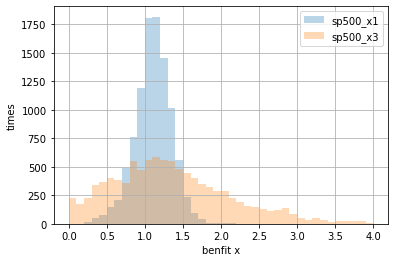

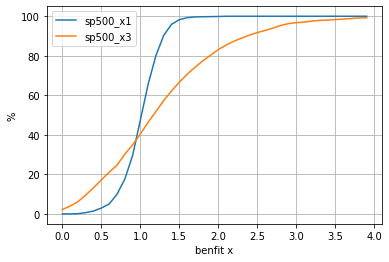

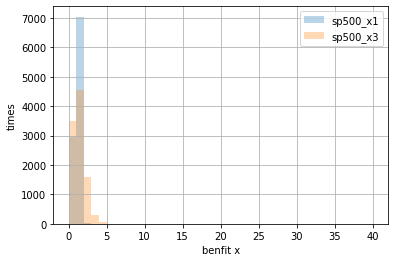

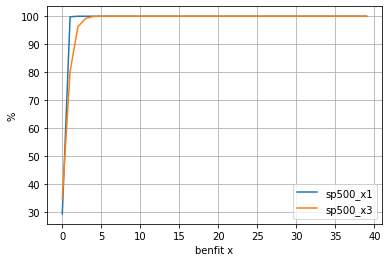

1年 sp500: mean=1.1072394872598688 min=0.2702205882352941 max=2.248322147651007
1年 sp500_x3: mean=1.3745176741869785 min=0.008498299250984685 max=5.649818601389541


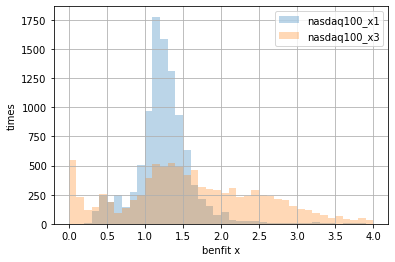

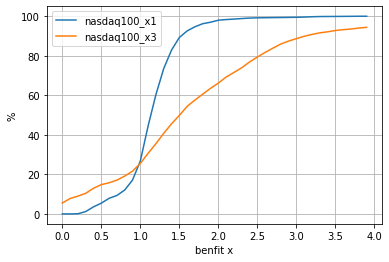

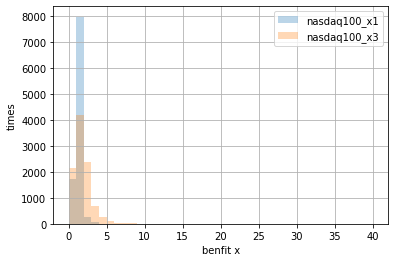

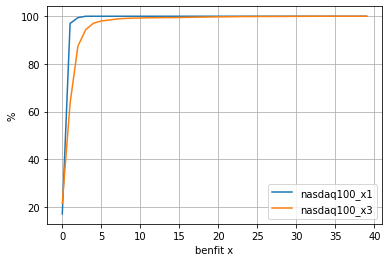

1年 nasdaq100: mean=1.2469714669914087 min=0.28484437711142807 max=3.861645558306825
1年 nasdaq100_x3: mean=1.9364567138274287 min=0.0045563788204038514 max=32.42065646155259


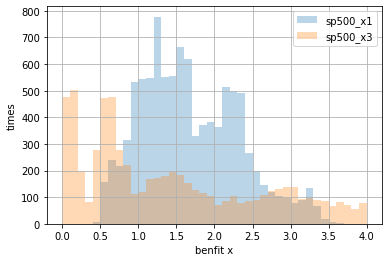

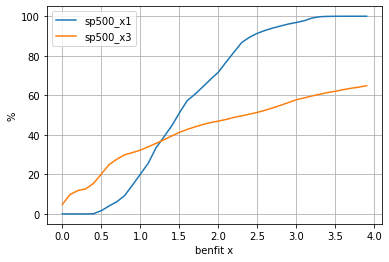

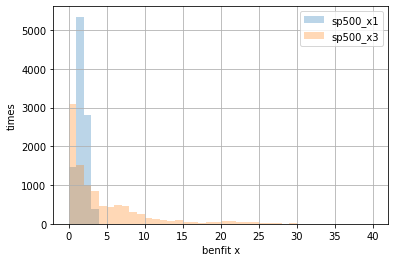

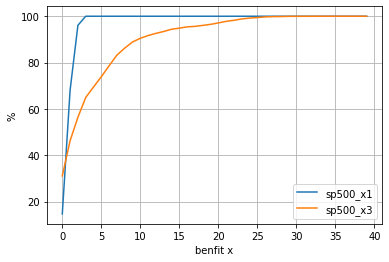

5年 sp500: mean=1.6817663569525965 min=0.4734411085450347 max=3.605838055658627
5年 sp500_x3: mean=4.37253359087051 min=0.005598528706445664 max=33.19767437051212


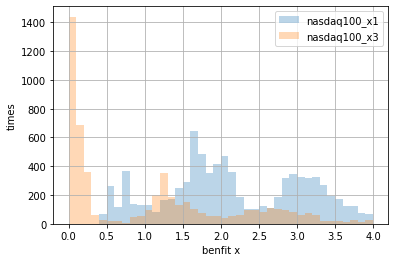

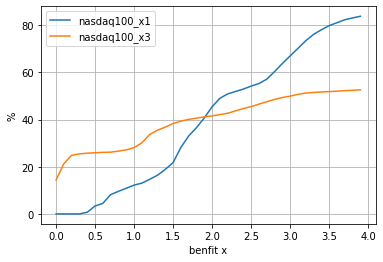

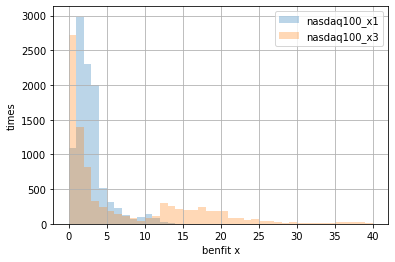

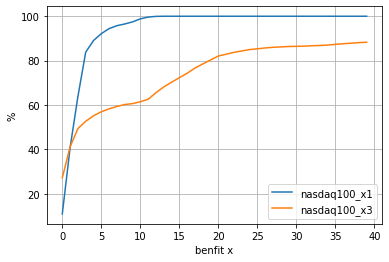

5年 nasdaq100: mean=2.895963553308439 min=0.41476456146876295 max=13.078037383590614
5年 nasdaq100_x3: mean=21.824492477888338 min=0.004534898736231825 max=489.76796169095735


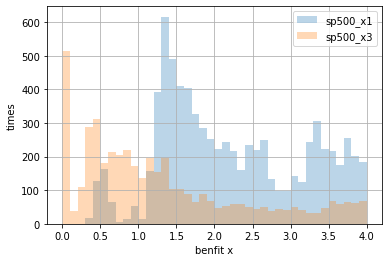

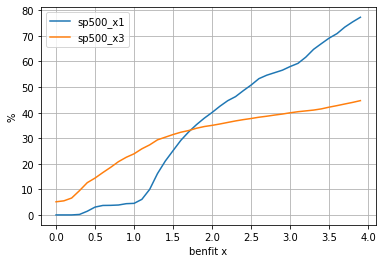

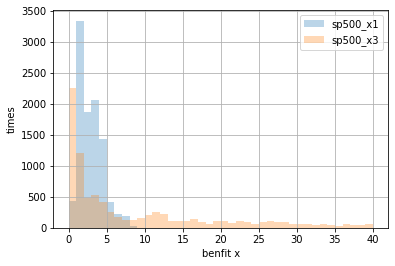

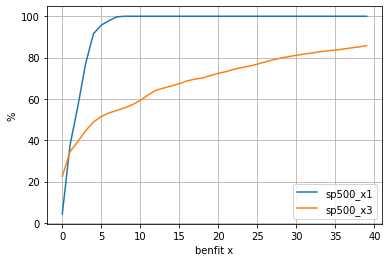

10年 sp500: mean=2.8838640531295168 min=0.37038206504578464 max=8.427784058733994
10年 sp500_x3: mean=17.557114992264207 min=0.0006401290361442512 max=170.8954437664756


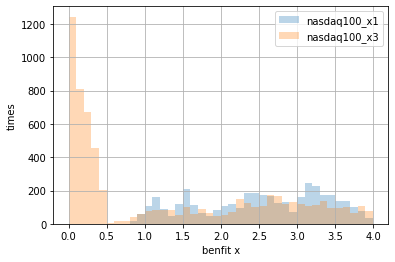

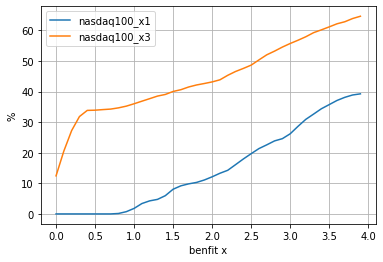

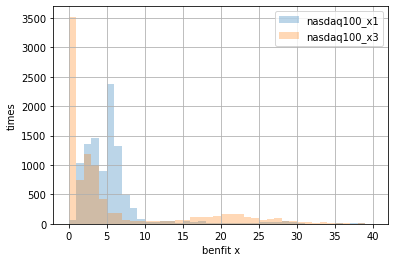

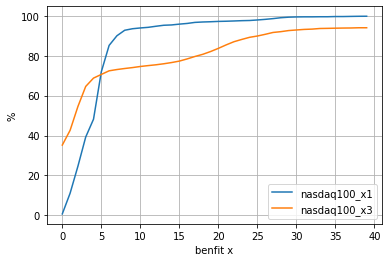

10年 nasdaq100: mean=5.591855077063155 min=0.8599327916431425 max=41.3910244094119
10年 nasdaq100_x3: mean=58.6100925218377 min=0.011557035432017668 max=5850.0467949400645


In [39]:
show_hist('exe1')

In [15]:
def show_hakohige(name, years=[1,5,10], ):
    for kk in ['sp500', 'nasdaq100', ]:
        for n in years:
            labels = []
            # 箱ひげ図
            fig, ax = plt.subplots()
            plt.title(f'{kk} {n} year')
            # ラベル名
            plt.xlabel('year')
            plt.ylabel('benefit x')
            # Y軸のメモリの長さ
            plt.grid()
            points = []
            for k in [kk, kk+'_x3']: 
                labels.append(('x1' if k[-1]=='0' else 'x3'))
                points.append(results[k][name][n])
            ax.boxplot(points, showfliers=False)
            ax.set_xticklabels(labels)
            plt.show()

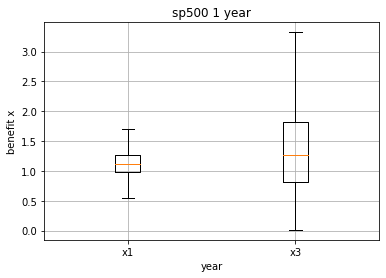

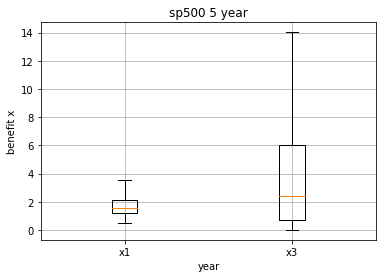

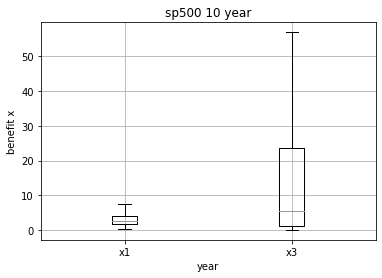

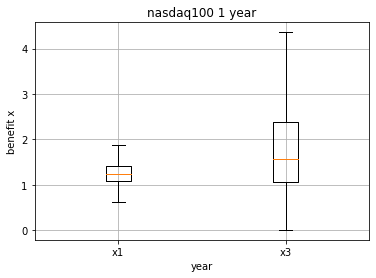

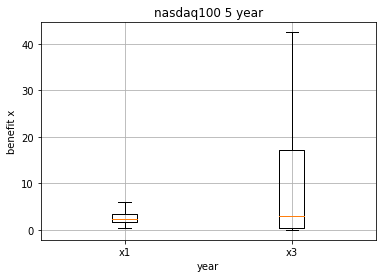

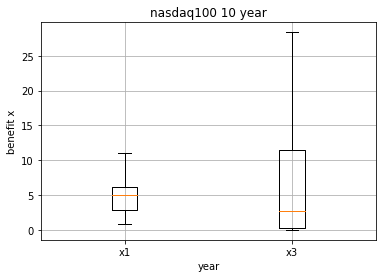

In [16]:
show_hakohige('exe1')

# N年間積立投資をした場合

In [42]:
def exe2(values, day_num, iteration):
    res = []
    starts = np.random.choice(np.arange(len(values)-day_num), iteration) 
    for start in starts:
        res.append(values[start+day_num-1]*np.mean(1/values[start:start+day_num].values))
    return res

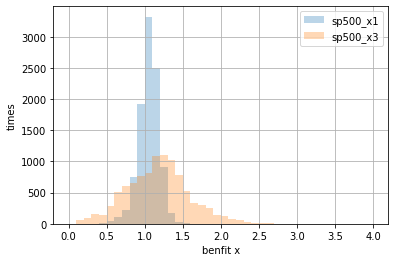

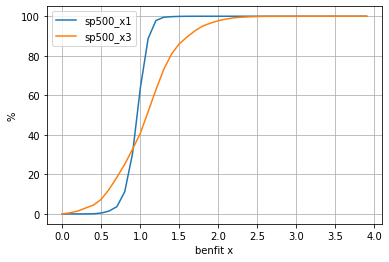

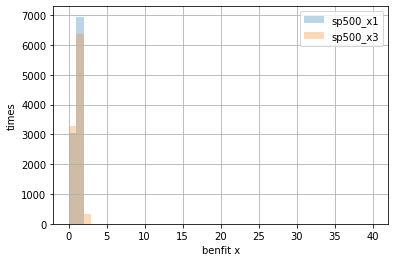

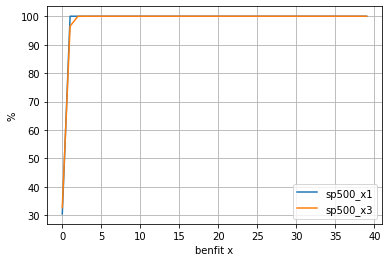

1年 sp500: mean=1.053392948324525 min=0.47399834619680364 max=1.7209347850251886
1年 sp500_x3: mean=1.1806178171056227 min=0.11185028825214104 max=3.165447680045356


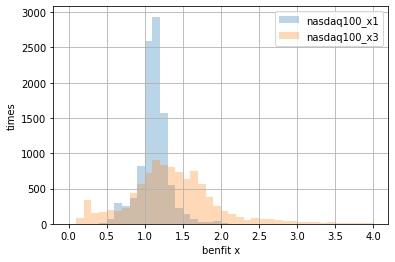

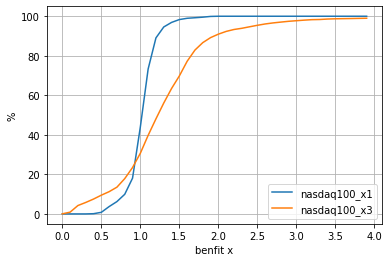

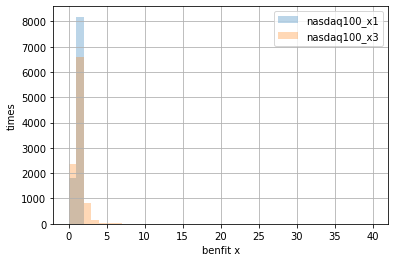

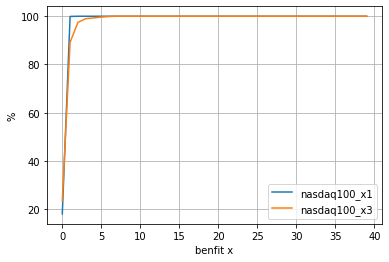

1年 nasdaq100: mean=1.1183598583961671 min=0.4563077304429209 max=2.076740246783032
1年 nasdaq100_x3: mean=1.3939017796564757 min=0.0778641493538016 max=7.846134818888072


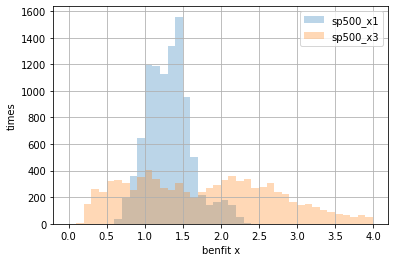

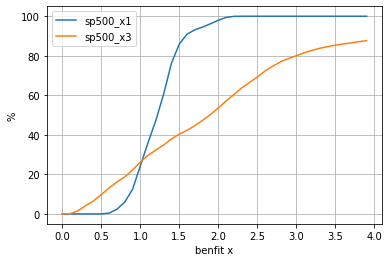

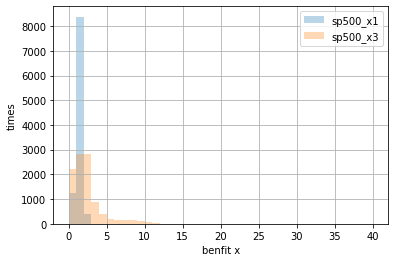

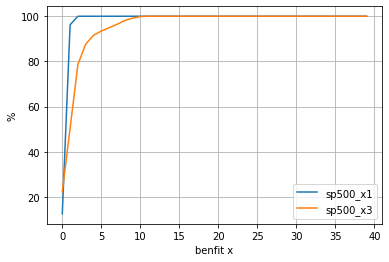

5年 sp500: mean=1.3250444519808966 min=0.5972575040408709 max=2.3179815974334024
5年 sp500_x3: mean=2.3703847784221668 min=0.15974594389455807 max=11.952976927442215


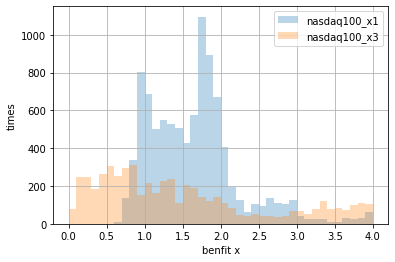

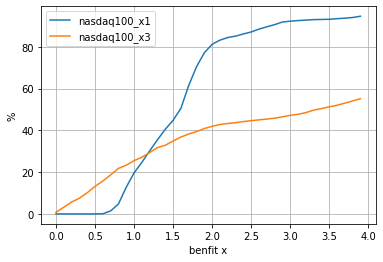

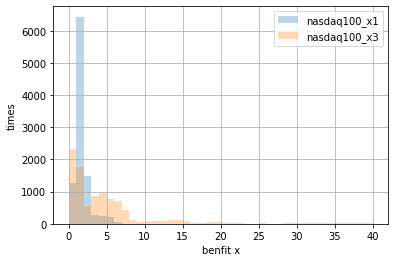

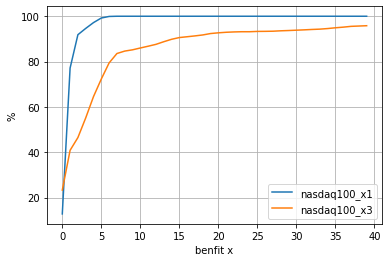

5年 nasdaq100: mean=1.8287171203512076 min=0.6775919654367238 max=7.176433238817956
5年 nasdaq100_x3: mean=7.697712832515142 min=0.06436521678736634 max=185.82172416154785


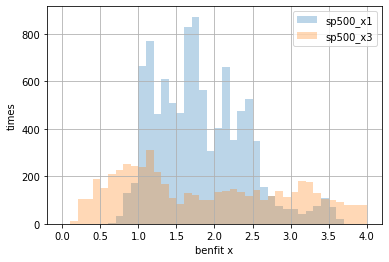

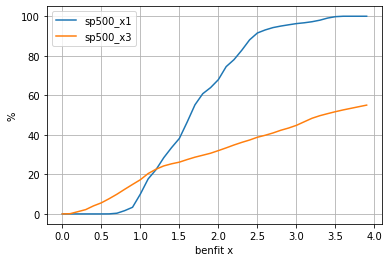

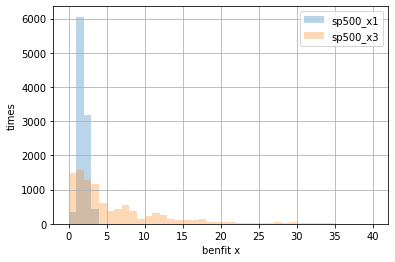

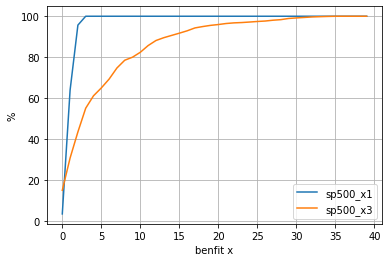

10年 sp500: mean=1.819879525291387 min=0.6926620154558404 max=3.670100693720371
10年 sp500_x3: mean=5.98984220796004 min=0.1270827077917132 max=36.82164724675499


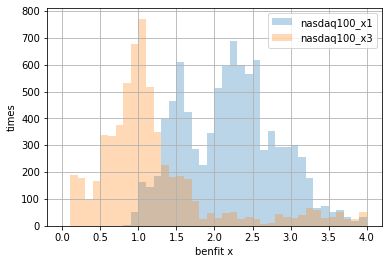

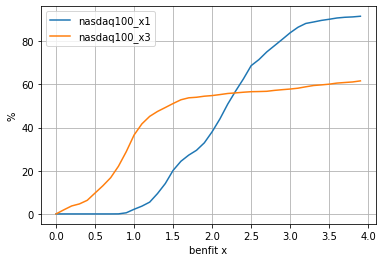

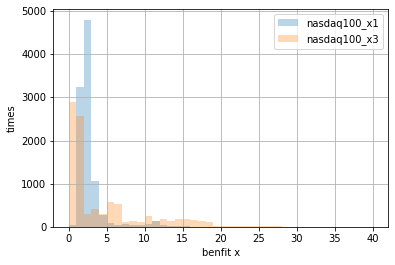

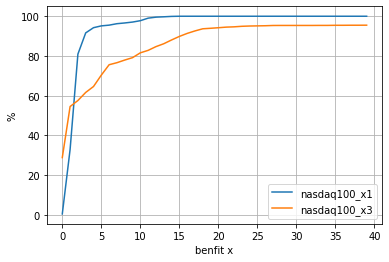

10年 nasdaq100: mean=2.6861423239946287 min=0.8859919857628307 max=15.495453399441045
10年 nasdaq100_x3: mean=18.292202072052675 min=0.1042291980150744 max=1046.6934902133123


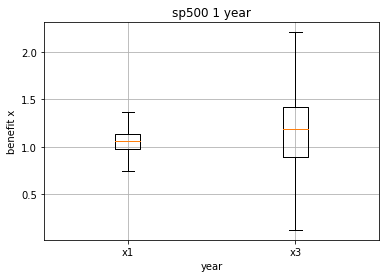

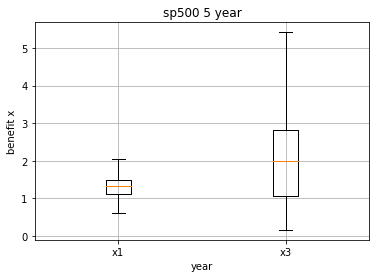

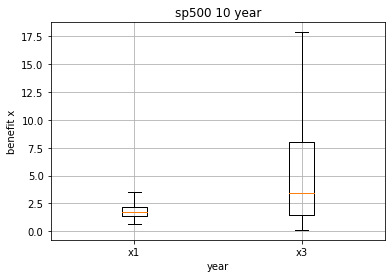

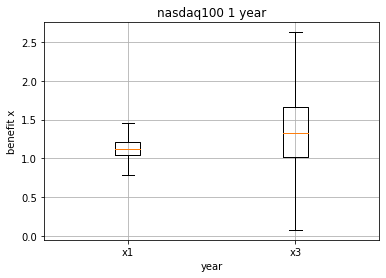

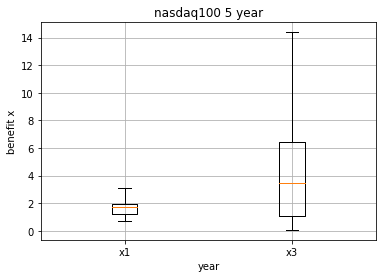

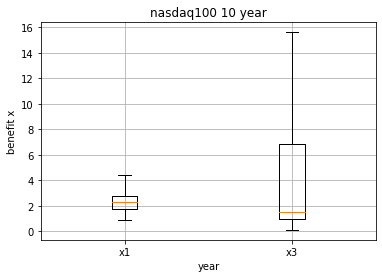

In [43]:
make_data(exe2, 'exe2', iteration=10000)
show_hist('exe2')
show_hakohige('exe2')